In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
from collections import Counter

In [34]:


def generate_samples(df, label, feature_columns, n_samples):
    """
    Generate new samples for a given class by randomly sampling feature values
    within the range of existing samples.
    """
    class_df = df[df[label_column] == label]
    new_samples = []
    
    for _ in range(n_samples):
        new_sample = {}
        for feature in feature_columns:
            min_val = class_df[feature].min()
            max_val = class_df[feature].max()
            new_sample[feature] = np.random.uniform(min_val, max_val)
        new_sample[label_column] = label
        new_samples.append(new_sample)
    
    return pd.DataFrame(new_samples)

def similarity_based_sampling(df, label_column, feature_columns, min_samples=5, 
                              max_samples=None, similarity_threshold=0.8, 
                              sampling_strategy='auto', balance_ratio=0.5):
    """
    Perform similarity-based sampling on the dataset with controlled over-sampling.
    
    :param df: pandas DataFrame containing the dataset
    :param label_column: name of the column containing class labels
    :param feature_columns: list of column names to use as features
    :param min_samples: minimum number of samples to keep for each class
    :param max_samples: maximum number of samples for any class after balancing
    :param similarity_threshold: threshold for cosine similarity
    :param sampling_strategy: sampling strategy for SMOTE
    :param balance_ratio: ratio of minority to majority class samples
    :return: DataFrame with balanced samples
    """
    
    label_counts = Counter(df[label_column])
    max_count = max(label_counts.values())
    
    if max_samples is None:
        max_samples = max_count
    
    selected_samples = []
    generated_samples = pd.DataFrame()
    
    for label, count in label_counts.items():
        label_df = df[df[label_column] == label]
        
        if count < min_samples:
            selected_samples.extend(label_df.index)
            n_generate = min_samples - count
            new_samples = generate_samples(df, label, feature_columns, n_generate)
            generated_samples = pd.concat([generated_samples, new_samples], ignore_index=True)
        elif count <= min_samples:
            selected_samples.extend(label_df.index)
        else:
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(label_df[feature_columns])
            
            similarity_matrix = cosine_similarity(features_scaled)
            
            selected = set()
            for i in range(similarity_matrix.shape[0]):
                if i not in selected:
                    selected.add(i)
                    similar = np.where(similarity_matrix[i] > similarity_threshold)[0]
                    selected.update(similar[:max(1, len(similar)//2)])
            
            if len(selected) < min_samples:
                remaining = set(range(similarity_matrix.shape[0])) - selected
                selected.update(list(remaining)[:min_samples - len(selected)])
            
            selected_samples.extend(label_df.iloc[list(selected)].index)
    
    selected_df = df.loc[selected_samples]
    combined_df = pd.concat([selected_df, generated_samples], ignore_index=True)
    
    # Calculate target samples for each class
    target_samples = int(max(min_samples, balance_ratio * max_count))
    target_samples = min(target_samples, max_samples)
    
    # Prepare sampling strategy
    class_counts = Counter(combined_df[label_column])
    sampling_dict = {label: max(count, min(target_samples, max_samples)) 
                     for label, count in class_counts.items()}
    
    # Apply SMOTE with controlled sampling
    smote = SMOTE(sampling_strategy=sampling_dict, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(combined_df[feature_columns], combined_df[label_column])
    
    resampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
    resampled_df[label_column] = y_resampled
    
    return resampled_df

# Example usage
# resampled_df = similarity_based_sampling(df, 'label_column', feature_columns, 
#                                          min_samples=5, max_samples=1000, 
#                                          similarity_threshold=0.8, balance_ratio=0.5)
# print(resampled_df[label_column].value_counts())

In [27]:
# 加载数据
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")

In [28]:
df.fillna(df.select_dtypes(include='number').mean(),inplace=True)

In [29]:
# 区分点位
no_calc_df = df[df['label']=='inner']
train_df = df[df['label']=='fish_net']

In [30]:
train_df['NEW_TZ'].value_counts().to_dict()

{'腐中层壤质黄色石灰土': 6323,
 '腐薄层壤质黄色石灰土': 4623,
 '腐厚层壤质黄色石灰土': 2256,
 '腐中层硅质黄壤': 2006,
 '腐中层灰泥质黄壤': 1983,
 '腐中层泥质黄壤': 1438,
 '腐厚层灰泥质黄壤': 1252,
 '腐薄层硅质黄壤': 1114,
 '中层壤质黄色石灰土': 1071,
 '腐薄层灰泥质黄壤': 804,
 '腐薄层泥质黄壤': 778,
 '腐中层黏质黄色石灰土': 734,
 '薄层壤质黄色石灰土': 603,
 '腐厚层泥质黄壤': 536,
 '腐厚层硅质黄壤': 499,
 '厚层壤质黄色石灰土': 439,
 '中层灰泥质黄壤': 380,
 '中层黏质黄色石灰土': 331,
 '石灰泥田': 289,
 '腐中层暗泥质黄壤': 270,
 '腐薄层黏质黄色石灰土': 229,
 '浅石灰泥田': 219,
 '厚层灰泥质黄壤': 210,
 '潮泥田': 202,
 '腐薄层暗泥质黄壤': 194,
 '中层硅质黄壤': 190,
 '腐厚层黏质黄色石灰土': 183,
 '薄层泥质黄壤': 145,
 '腐厚层泥质黄棕壤': 144,
 '中层泥质黄壤': 143,
 '薄层灰泥质黄壤': 142,
 '黄浅白粉泥田': 125,
 '腐中层砂泥质黄壤': 122,
 '腐中层红泥质黄壤': 110,
 '潮砂泥田': 109,
 '腐薄层泥质黄棕壤': 106,
 '腐薄层红泥质黄壤': 91,
 '腐中层泥质黄棕壤': 90,
 '黄白粉泥田': 83,
 '中层红泥质黄壤': 83,
 '厚层黏质黄色石灰土': 60,
 '薄层硅质黄壤': 60,
 '黄浅鳝泥田': 54,
 '腐厚层暗泥质黄壤': 53,
 '腐厚层红泥质黄壤': 53,
 '黄黄泥田': 52,
 '厚层红泥质黄壤': 49,
 '薄层壤质中性紫色土': 46,
 '腐中层壤质中性紫色土': 46,
 '青灰泥田': 43,
 '厚层泥质黄壤': 43,
 '青潮泥田': 42,
 '薄层红泥质黄壤': 42,
 '紫泥田': 32,
 '浅鳝泥田': 32,
 '腐薄层壤质中性紫色土': 31,
 '黄浅砂泥田': 30,
 '厚层硅质黄壤': 28,
 '轻漂白粉泥田': 27,
 '黄浅

In [31]:
feature_columns = ['aligned_Analytical Hillshading', 'aligned_Aspect',
       'aligned_Channel Network Base Level',
       'aligned_Channel Network Distance', 'aligned_Closed Depressions',
       'aligned_Convergence Index', 'aligned_dem', 
       'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
       'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
       'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
       'aligned_Plan Curvature', 'aligned_PRE2022_mean',
       'aligned_Profile Curvature', 'aligned_Relative Slope Position',
       'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
       'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
       'aligned_Valley Depth', 'aligned_vari', 'clipped_dem','MRRTF', 'MRVBF', 'slope_postion_101']
# 标签值
label_column = 'NEW_TZ'

In [40]:
resampled_df = similarity_based_sampling(df, label_column, feature_columns, 
                                         min_samples=6, max_samples=1000, 
                                         similarity_threshold=0.98, balance_ratio=0.5)
print(resampled_df[label_column].value_counts())

NEW_TZ
腐中层壤质黄色石灰土    6648
腐薄层壤质黄色石灰土    4845
腐厚层壤质黄色石灰土    2364
腐中层硅质黄壤       2210
腐中层灰泥质黄壤      2111
              ... 
黄鳝泥田          1000
中漂鳝泥田         1000
浅黄泥田          1000
浅鳝泥田          1000
腐中层黏质中性紫色土    1000
Name: count, Length: 114, dtype: int64


In [41]:
resampled_df

,aligned_Analytical Hillshading,aligned_Aspect,aligned_Channel Network Base Level,aligned_Channel Network Distance,aligned_Closed Depressions,aligned_Convergence Index,aligned_dem,aligned_ETP2022_mean,aligned_evi,aligned_LS-Factor,...,aligned_TMP2022_mean,aligned_Topographic Wetness Index,aligned_Total Catchment Area,aligned_Valley Depth,aligned_vari,clipped_dem,MRRTF,MRVBF,slope_postion_101,NEW_TZ
0,0.821602,4.330196,746.930359,8.869629,0.0,-0.450430,755.799988,894.666687,0.629311,29.201853,...,160.833328,3.736111,299.832001,104.505737,0.395760,755.799988,1.749430e-04,2.672201e-04,2.000000,腐薄层泥质黄壤
1,0.315856,5.848521,824.568176,70.831848,0.0,3.590487,895.400024,877.333313,0.387367,11.164645,...,157.000000,3.021536,84.143555,4.558105,0.471354,895.400024,9.855905e-02,2.782072e-02,5.000000,腐薄层泥质黄壤
2,1.143136,0.667835,840.598999,44.401001,0.0,-0.460930,885.000000,877.333313,0.353424,34.148487,...,157.000000,3.083230,277.225494,42.737183,0.225806,885.000000,4.529005e-08,3.995508e-07,4.000000,腐薄层泥质黄壤
3,0.466586,6.184909,658.269226,12.530762,0.0,0.823992,670.799988,895.500000,0.222032,24.558018,...,161.666672,4.521689,358.763886,100.718628,0.549107,670.799988,6.933413e-03,2.654332e-02,2.000000,腐薄层泥质黄壤
4,0.288440,5.562632,997.134827,81.565125,0.0,1.026257,1078.699951,861.916687,0.270620,13.995391,...,153.500000,4.010557,212.432388,5.399170,0.526882,1078.699951,9.284638e-02,1.138735e-01,5.000000,腐薄层泥质黄壤
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128466,0.916008,3.519962,615.117180,18.162188,0.0,5.827701,633.279368,941.861998,0.317507,5.981256,...,166.221800,4.264505,146.755826,58.061249,-0.002928,633.279368,6.050998e-01,4.580832e-01,4.000000,黄黄白粉泥田
128467,0.687280,4.338323,652.589739,3.278989,0.0,-2.328997,655.868728,928.924474,0.318495,11.912779,...,161.837231,5.413431,502.212163,82.129535,0.010996,655.868728,1.309430e-01,1.233606e+00,1.398663,黄黄白粉泥田
128468,0.926041,3.370844,629.555287,9.223306,0.0,0.330198,638.778593,940.061326,0.364537,5.189142,...,166.014365,4.324031,130.779105,40.284686,0.019550,638.778593,4.987285e-01,6.285514e-01,4.000000,黄黄白粉泥田
128469,0.661661,4.489886,692.428639,1.435233,0.0,-6.837498,693.863872,931.879160,0.340205,34.687794,...,162.257909,7.655851,8223.279920,78.963383,0.024246,693.863872,1.134394e-01,8.323148e-01,1.367534,黄黄白粉泥田


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# 假设您的数据存储在一个名为 'spatial_data.csv' 的文件中
# 每行包含经度和纬度信息
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")



In [11]:
df['NEW_TZ'].value_counts().to_dict()

{'腐中层壤质黄色石灰土': 6648,
 '腐薄层壤质黄色石灰土': 4845,
 '腐厚层壤质黄色石灰土': 2364,
 '腐中层硅质黄壤': 2210,
 '腐中层灰泥质黄壤': 2111,
 '腐中层泥质黄壤': 1642,
 '腐厚层灰泥质黄壤': 1321,
 '腐薄层硅质黄壤': 1186,
 '中层壤质黄色石灰土': 1144,
 '腐薄层泥质黄壤': 890,
 '腐中层黏质黄色石灰土': 871,
 '腐薄层灰泥质黄壤': 849,
 '薄层壤质黄色石灰土': 646,
 '腐厚层泥质黄壤': 595,
 '腐厚层硅质黄壤': 551,
 '中层黏质黄色石灰土': 467,
 '厚层壤质黄色石灰土': 464,
 '中层灰泥质黄壤': 429,
 '石灰泥田': 389,
 '浅石灰泥田': 321,
 '腐中层暗泥质黄壤': 295,
 '腐薄层黏质黄色石灰土': 246,
 '潮泥田': 241,
 '厚层灰泥质黄壤': 236,
 '中层硅质黄壤': 230,
 '腐薄层暗泥质黄壤': 209,
 '腐厚层黏质黄色石灰土': 191,
 '中层泥质黄壤': 179,
 '黄浅白粉泥田': 165,
 '薄层泥质黄壤': 162,
 '薄层灰泥质黄壤': 156,
 '腐厚层泥质黄棕壤': 154,
 '腐中层砂泥质黄壤': 135,
 '潮砂泥田': 132,
 '腐中层红泥质黄壤': 117,
 '黄白粉泥田': 110,
 '腐薄层泥质黄棕壤': 107,
 '中层红泥质黄壤': 97,
 '腐薄层红泥质黄壤': 95,
 '腐中层泥质黄棕壤': 92,
 '黄黄泥田': 75,
 '薄层硅质黄壤': 71,
 '黄浅鳝泥田': 71,
 '厚层黏质黄色石灰土': 65,
 '腐厚层红泥质黄壤': 58,
 '腐厚层暗泥质黄壤': 56,
 '浅鳝泥田': 55,
 '青灰泥田': 53,
 '青潮泥田': 53,
 '腐中层壤质中性紫色土': 52,
 '紫泥田': 52,
 '薄层壤质中性紫色土': 51,
 '厚层红泥质黄壤': 50,
 '厚层泥质黄壤': 49,
 '薄层红泥质黄壤': 46,
 '酸浅紫泥田': 37,
 '黄浅砂泥田': 37,
 '轻漂潮泥田': 35,
 '腐薄层壤质中性紫色土': 34,
 '黄浅灰

In [12]:
df = df[df['NEW_TZ']=='腐中层壤质黄色石灰土']

In [13]:
X = df[['lon','lat']].values

In [23]:
env_features = df[['aligned_Aspect',
       'aligned_Channel Network Base Level',
       'aligned_Channel Network Distance', 'aligned_Closed Depressions',
       'aligned_Convergence Index', 'aligned_dem', 
       'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
       'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
       'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
       'aligned_Plan Curvature', 'aligned_PRE2022_mean',
       'aligned_Profile Curvature', 'aligned_Relative Slope Position',
       'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
       'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
       'aligned_Valley Depth', 'aligned_vari', 'clipped_dem','MRRTF', 'MRVBF', 'slope_postion_101']].values

# 仅考虑空间位置

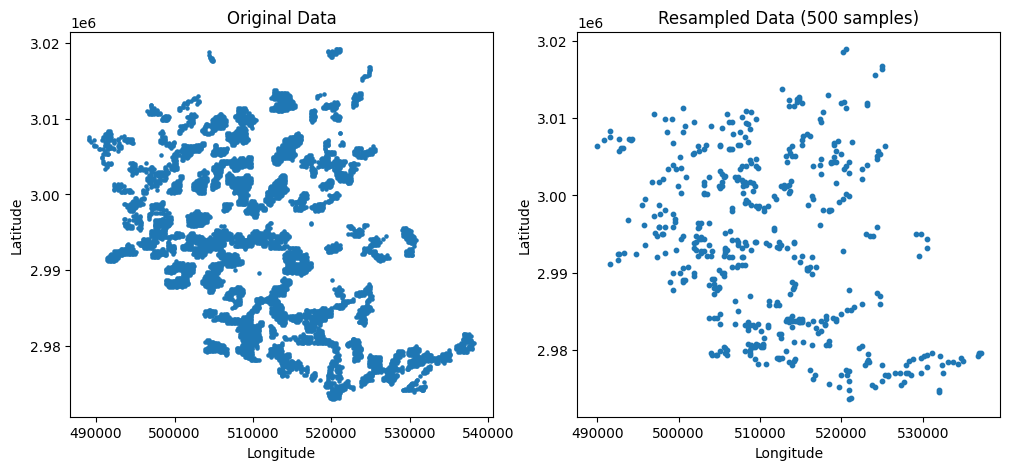

In [22]:


# 设定目标采样数量
target_samples = 500

# 使用 DBSCAN 聚类算法进行空间稀疏化
db = DBSCAN(eps=0.01, min_samples=1)
db.fit(X)
labels = db.labels_
unique_labels = set(labels)

# 选择每个聚类中的一个代表性点作为采样点
resampled_X = []
for label in unique_labels:
    if label != -1:  # 排除噪声点
        cluster_points = X[labels == label]
        resampled_X.append(cluster_points[np.random.choice(len(cluster_points))])

# 如果采样点数量仍然大于目标数量,进一步随机删减
if len(resampled_X) > target_samples:
    resampled_X = np.array(resampled_X)
    resampled_X = resampled_X[np.random.choice(len(resampled_X), target_samples, replace=False)]

# 创建原始数据和重采样数据的可视化
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 绘制原始数据
ax[0].scatter(X[:, 0], X[:, 1], s=5)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# 绘制重采样数据
ax[1].scatter(resampled_X[:, 0], resampled_X[:, 1], s=10)
ax[1].set_title(f'Resampled Data ({len(resampled_X)} samples)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

# 考虑环境因子

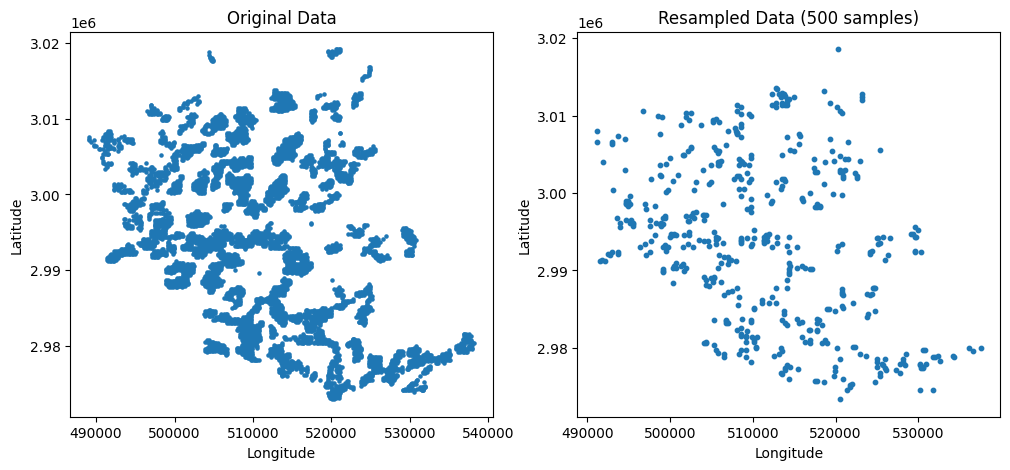

In [24]:


# Set the target sample count
target_samples = 500

# Use DBSCAN clustering to perform spatial sparsification
db = DBSCAN(eps=0.01, min_samples=1)
db.fit(X)
labels = db.labels_
unique_labels = set(labels)

# Select a representative point from each cluster as a sample
resampled_X = []
resampled_env_features = []
for label in unique_labels:
    if label != -1:  # Exclude noise points
        cluster_points = X[labels == label]
        cluster_env_features = env_features[labels == label]
        
        # Calculate the distance of each point to the cluster center, select the closest one as representative
        cluster_center = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
        representative_idx = np.argmin(distances)
        
        resampled_X.append(cluster_points[representative_idx])
        resampled_env_features.append(cluster_env_features[representative_idx])

# If the number of sample points is still greater than the target, randomly reduce the sample
if len(resampled_X) > target_samples:
    resampled_X = np.array(resampled_X)
    resampled_env_features = np.array(resampled_env_features)
    
    # Randomly select the target number of points
    selected_indices = np.random.choice(len(resampled_X), target_samples, replace=False)
    resampled_X = resampled_X[selected_indices]
    resampled_env_features = resampled_env_features[selected_indices]

# Create a dataframe for the resampled data
resampled_df = pd.DataFrame({
    'longitude': [p[0] for p in resampled_X],
    'latitude': [p[1] for p in resampled_X]
})

for i, col in enumerate(env_features.T):
    resampled_df[f'env_feature_{i}'] = resampled_env_features[:, i]

# Create visualizations for the original and resampled data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the original data
ax[0].scatter(df['longitude'], df['latitude'], s=5)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Plot the resampled data
ax[1].scatter(resampled_df['longitude'], resampled_df['latitude'], s=10)
ax[1].set_title(f'Resampled Data ({len(resampled_df)} samples)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()